# I. IMPORTS

In [1]:
# All relevant imports for this file are done here. 
# Run the following in terminal if errors are obtained: set DJANGO_SETTINGS_MODULE=ms2ldaviz.settings
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
basedir = 'C:\\Users\\rpetr\\OneDrive\\Desktop\\DISS_CODE\\ms2ldaviz\\ms2ldaviz'
sys.path.append(basedir)
import django
import json
django.setup()
from basicviz.models import Experiment, Alpha, Mass2MotifInstance, FeatureInstance, Feature, Document, Mass2Motif, DocumentMass2Motif, FeatureMass2MotifInstance
import numpy as np
import pylab as plt
import csv
from scipy.special import polygamma as pg
from scipy.special import psi as psi
import pickle 
import copy

MEDIA_ROOT is C:\Users\rpetr\OneDrive\Desktop\DISS_CODE\ms2ldaviz\ms2ldaviz\media


# II. COMMON VARIABLES

In [2]:
# Small number used throughout the prototype for normalisation and e-step.
SMALL_NUMBER = 1e-100

# III. IMPORT LDA DICT FILES

In [3]:
# Run this line if you wish to run the experiment with low thresholding. 
file = open('mb_lower_thresh.dict','r')
lda_dict_low_thresh = pickle.load(file)

In [4]:
# Run this line if you wish to run the experiment with high thresholding. 
file = open('mb_normal_thresh.dict','r')
lda_dict_high_thresh = pickle.load(file)

In [5]:
# Create a copy of the experiment dictionary for this prototype.
lda_dict=copy.deepcopy(lda_dict_low_thresh)

# IV. MAP DOCUMENTS/WORDS/TOPICS TO INDICES

## MAP DOCUMENTS TO INDICES

In [6]:
# Get all the documents in the corpus of the file. 
doc_list=lda_dict['corpus'].keys()

In [7]:
# Only for reference purposes (from SQL SELECT) when choosing a document.
# 269485	eawag_0503.ms
# 270314	washington_0978.ms
# 270414	eawag_0758.ms
# 271247	eawag_0759.ms
# 269323 	eawag_0730.ms

In [8]:
# Manually choose a document by name. 
chosen_document=['eawag_0730.ms']

In [9]:
# Map documents to indices.
unique_docs=copy.deepcopy(lda_dict['doc_index'])

In [10]:
# Get document index of chosen document. 
chosen_document_index = unique_docs[chosen_document[0]]

## MAP WORDS TO INDICES

In [11]:
# Map words to indices. 
unique_words=copy.deepcopy(lda_dict['word_index'])

## MAP TOPICS TO INDICES

In [12]:
# Map topics to indices. 
unique_topics = copy.deepcopy(lda_dict['topic_index'])

# V. GET HYPERPARAMETERS

## GET ALPHA

In [13]:
# Get the Alpha vector from the experiment dictionary. 
alpha_vector = copy.deepcopy(lda_dict['alpha'])
alpha_vector = np.array(alpha_vector)

## GET BETA

In [14]:
# Get all the Beta values from the experiment input dictionary. 
beta_prep_list = []
for topic in lda_dict['beta']: 
    for word in lda_dict['beta'][topic]:
        beta_prep_list.append([unique_topics[topic],unique_words[word],lda_dict['beta'][topic][word]])

In [15]:
# Create a Beta matrix and populate it. 
K = len(unique_topics)
W = len(unique_words)
pivot_table = np.zeros((K, W)).astype('float')
i = 0
max = len(beta_prep_list)
while i<max:
    pivot_table[int(beta_prep_list[i][0]),int(beta_prep_list[i][1])]=beta_prep_list[i][2]
    i+=1

In [16]:
# Normalise the Beta matrix. 
pivot_table_normalised = np.array(pivot_table)
i = 0
while i<K: 
    row = pivot_table_normalised[i, :]
    adjusted_row = row + SMALL_NUMBER
    normalised_row = adjusted_row / np.sum(adjusted_row)
    np.sum(normalised_row)
    pivot_table_normalised[i, :] = normalised_row
    i+=1

# VI. GET VARIATIONAL INFERENCE PARAMETERS

## GET ORIGINAL GAMMA (IN NORMALISED/THETA FORM)

In [17]:
# Get original normalised Gamma values from experiment dictionary input. 
original_theta = copy.deepcopy(lda_dict['theta'][chosen_document[0]])

## GET ORIGINAL PHI

In [18]:
# Get original Phi values from experiment dictionary input. 
phi_matrix_original = copy.deepcopy(lda_dict['phi'])

# VII. E-STEP

## INITIALISE CORPUS BEFORE E-STEP (1 document only)

In [19]:
# Get corpus as a list first. 
corpus_dict_list = []
temp_dict = copy.deepcopy(lda_dict['corpus'][chosen_document[0]])
for word in temp_dict:
    corpus_dict_list.append([chosen_document_index, int(unique_words[word]),int(temp_dict[word])])

In [20]:
# Create corpus_dict for e-step in the format => doc_id:{word_id:intensity}
corpus_dict={}
temp_dict={}
for line in corpus_dict_list:
    temp_dict.update({line[1]:line[2]})
corpus_dict.update({corpus_dict_list[0][0]:temp_dict})

## Step 0 - E-step variables

In [21]:
# Define any missing variables for the e-step.
corpus = corpus_dict
beta_matrix = pivot_table_normalised

## Step 1 - Initialise phi matrix

In [22]:
# Initialise Phi in the format -> {doc:{word:[topic_array]}}
phi_matrix={}
for doc in corpus: 
    d = int(doc)
    phi_matrix[d] = {}
    for word in corpus[doc]:
        w = int(word)
        phi_matrix[d][w]=np.zeros(K)

## Step 2 - Initialise gamma matrix

In [23]:
# Initialise Gamma matrix. 
# As the prototype has only 1 document - we get a gamma vector of size K.
# doc_total = words/document
gamma_matrix=np.zeros((int(len(corpus)),int(K))) #3x500 shape
for doc in corpus:
    doc_total=0.0
    for word in corpus[doc]:
        doc_total += corpus[doc][word]
    gamma_matrix[0,:] = alpha_vector + 1.0*(doc_total/K)

## Step 3 - repeat until convergence loop

In [24]:
# The code below has been refactored from lda.py at https://github.com/sdrogers/ms2ldaviz/blob/master/lda/code/lda.py
# This is an implementation of Blei's loop as described on http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf, page 1005.
test_list = []
iterations = 1000
n_words = int(len(unique_words))
temp_beta = np.zeros((K, n_words))
current_gamma = np.copy(gamma_matrix)
for i in range(iterations):   
    prev_gamma = np.copy(current_gamma)
    for doc in corpus:
        d = int(doc)
        doc_dict = corpus[doc]
        temp_gamma = np.zeros(K) + alpha_vector
        for word in doc_dict:  
            w = int(word)
            log_phi_matrix = np.log(beta_matrix[:,w]) + psi(gamma_matrix[0,:]).T #changed here for 1 doc prototype
            log_phi_matrix = np.exp(log_phi_matrix - log_phi_matrix.max())
            phi_matrix[d][w] = log_phi_matrix/log_phi_matrix.sum()
            temp_gamma += phi_matrix[d][w]*corpus[doc][word]
            temp_beta[:,w] += phi_matrix[d][w] * corpus[doc][word]
        gamma_matrix[0,:] = temp_gamma #changed here for 1 doc prototype
        pos = np.where(gamma_matrix[0,:]<SMALL_NUMBER)[0] #changed here for 1 doc prototype
        gamma_matrix[0,pos] = SMALL_NUMBER #changed here for 1 doc prototype
    current_gamma = np.copy(gamma_matrix)
    gamma_diff = ((current_gamma - prev_gamma)**2).sum()
    test_list.append([i, gamma_diff])

# VIII. COMPARISON OF GAMMA & PHI (original vs calculated in prototype) 

## Gamma comparison / Theta comparison 

In [25]:
# Transform original gamma into a K-length vector. 
gamma_vector_original = np.zeros(K) 
for k,v in original_theta.items():
    pos = int(unique_topics[k])
    prob = v
    gamma_vector_original[pos] = prob

In [26]:
# Normalise original gamma vector. 
gamma_vector_original += SMALL_NUMBER
gamma_vector_original /= np.sum(gamma_vector_original)

In [27]:
# Create and normalise vector for calculated gamma. 
gamma_vector_calculated = np.zeros(K) 
gamma_vector_calculated = np.copy(gamma_matrix[0])
gamma_vector_calculated /= np.sum(gamma_vector_calculated)

In [28]:
# Test how the gamma values compare. Format-> [original_gamma, calculated_gamma, difference]
gamma_compare = np.zeros([K,3])
for i in range(K):
    gamma_compare[i,0] = gamma_vector_original[i]
    gamma_compare[i,1] = gamma_vector_calculated[i]
    gamma_compare[i,2] = abs(gamma_compare[i,0] - gamma_compare[i,1]) 
print('Max difference between gammas: ' + str(gamma_compare[:,2].max()))

Max difference between gammas: 0.020504000335506922


In [29]:
# CSV export of gamma value comparison. 
np.savetxt("compare_gamma_"+str(chosen_document[0])+".csv", gamma_compare, delimiter=",", fmt="%s")

## Phi comparison

In [30]:
# Get number of lines for comparison. 
# Create a numpy matrix with columns: word, topic, original_phi, calculated_phi, phi_diff, intensity.
count = 0 
doc_level = phi_matrix_original[chosen_document[0]]
for word in doc_level.keys():
    count += len(doc_level[word].keys()) 
phi_compare = np.zeros([count, 6])

In [31]:
# Populate the phi comparison matrix. 
i = 0
for word in doc_level.keys():
    for topic, phi in doc_level[word].items():
        phi_compare[i,0] = unique_words[word]
        phi_compare[i,1] = unique_topics[topic]
        phi_compare[i,2] = doc_level[word][topic] 
        phi_compare[i,3] = phi_matrix[chosen_document_index][unique_words[word]][unique_topics[topic]]
        phi_compare[i,4] = abs(phi_compare[i,2]-phi_compare[i,3])
        phi_compare[i,5] = corpus_dict[chosen_document_index][unique_words[word]]
        i+=1

In [32]:
# Check the maximal phi difference. 
print('Max difference between phi\'s: ' + str(phi_compare[:,4].max()))

Max difference between phi's: 0.9975509809202099


## Phi comparison (with materiality)

In [33]:
# Get the corpus words with the highest count/intensity/materiality. Create a list.
materiality_value = 10 # Manually change materiality here.
material_words = []
for doc in corpus_dict: 
    for word in corpus_dict[doc]:
        w = corpus_dict[doc][word]
        if int(w) > materiality_value:
            material_words.append([int(word), w]) 

In [34]:
# Create material words dictionary too if needed. 
material_words_dict = {}
for line in material_words:
    material_words_dict.update({line[0] : line[1]})

In [35]:
# Make array of material words list.
material_words_array = np.array(material_words)

In [36]:
# Choose material words for comparison loop.
material_words_list = list(material_words_array[:,0])

In [37]:
# Create phi comparison matrix filtered by the material words. 
phi_compare2 = []
for line in phi_compare: 
    line_word = line[0]
    if line_word in material_words_list:
        phi_compare2.append(line)
phi_compare2 = np.array(phi_compare2)
print('Max difference between phi\'s: ' + str(phi_compare2[:,4].max()))

Max difference between phi's: 0.45457304251944264


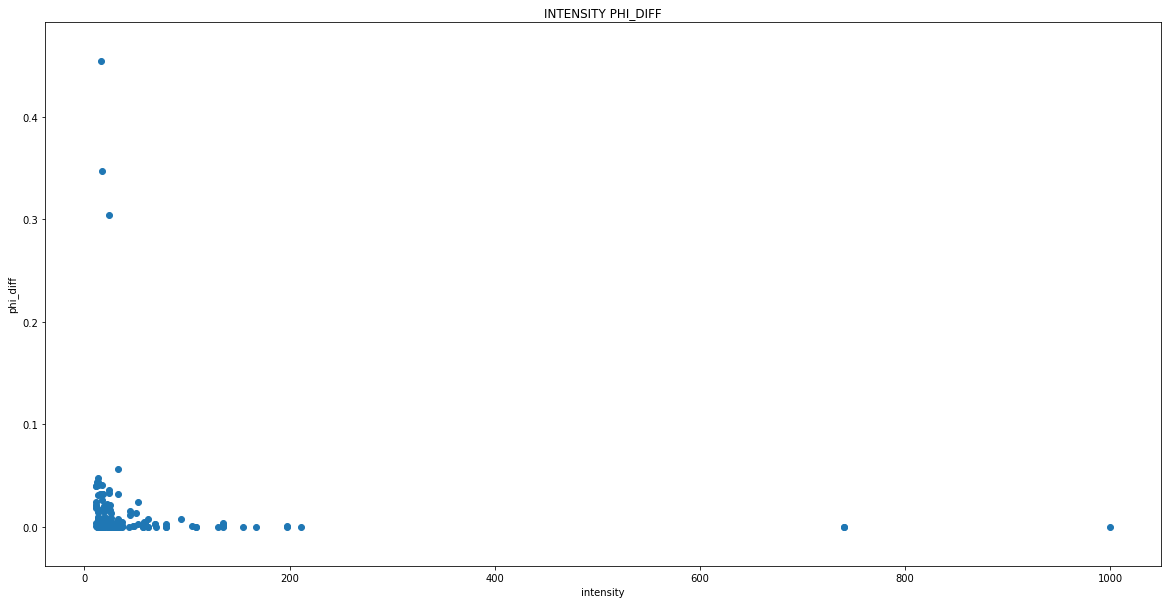

In [38]:
# Plot word intensity on x axis and phi difference on y axis of a scatterplot. 
x = phi_compare2[:,5]
y = phi_compare2[:,4]
fig = plt.figure()
scatterplot = fig.add_subplot(1,1,1)
plt.scatter(x,y)
fig.set_size_inches(20,10)
plt.title("INTENSITY PHI_DIFF")
plt.xlabel("intensity")
plt.ylabel("phi_diff")
plt.show()
fig.savefig(str(chosen_document[0])+".png")

In [39]:
# CSV export of phi comparison. 
np.savetxt("compare_phi_"+str(chosen_document[0])+".csv", phi_compare2, delimiter=",", fmt="%s")

In [40]:
sys.getsizeof(lda_dict)

1040

In [41]:
total = 0
for k in lda_dict.keys(): 
    total += sys.getsizeof(lda_dict[k])
    print (k,sys.getsizeof(lda_dict[k]),total)

('phi', 196880, 196880)
('features', 3146000, 3342880)
('doc_metadata', 196880, 3539760)
('K', 24, 3539784)
('word_index', 3146000, 6685784)
('topic_index', 49424, 6735208)
('doc_index', 196880, 6932088)
('beta', 49424, 6981512)
('topic_metadata', 49424, 7030936)
('alpha', 4272, 7035208)
('corpus', 196880, 7232088)
('overlap_scores', 196880, 7428968)
('theta', 196880, 7625848)
('gamma', 4096, 7629944)
